## Saneamiento de datos

### Librerias

In [2]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
import random
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
from surprise import Dataset, Reader, SVDpp, accuracy
from surprise.model_selection import train_test_split
import scipy.sparse as sp


### Datos

In [4]:
# Define the path to your local data folder
data_path = '../ml-100k'

# Check if the folder exists (opcional)
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The data folder {data_path} does not exist.")

# Load ratings: user id | item id | rating | timestamp
ratings_df = pd.read_csv(
    os.path.join(data_path, 'u.data'),
    sep='\t',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
    engine='python'
)

# Load users: user id | age | gender | occupation | zip code
users_df = pd.read_csv(
    os.path.join(data_path, 'u.user'),
    sep='|',
    names=['UserID', 'Age', 'Gender', 'Occupation', 'Zip-code'],
    engine='python'
)

# Define genre columns in the same order as in the u.item file
genre_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Define full column names for u.item
movie_cols = ['MovieID', 'Title', 'ReleaseDate', 'VideoReleaseDate', 'IMDbURL'] + genre_cols

# Load movies and keep only MovieID, Title, and genre columns
movies_df = pd.read_csv(
    os.path.join(data_path, 'u.item'),
    sep='|',
    names=movie_cols,
    usecols=['MovieID', 'Title'] + genre_cols,
    encoding='latin1',
    engine='python'
)

# Optional: print shape to verify loading
print(f"Ratings data shape: {ratings_df.shape}")
print(f"Users data shape: {users_df.shape}")
print(f"Movies data shape: {movies_df.shape}")


Ratings data shape: (100000, 4)
Users data shape: (943, 5)
Movies data shape: (1682, 21)


### Matriz de ratings user-item

In [5]:
# Create the ratings matrix (UserID as rows, MovieID as columns)
ratings_matrix = ratings_df.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Display a smaller subset to keep it readable (e.g., first 10 rows and columns)
subset_matrix = ratings_matrix.iloc[:10, :10]


# Show as styled HTML table
display(HTML(subset_matrix.to_html()))

MovieID,1,2,3,4,5,6,7,8,9,10
UserID,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN


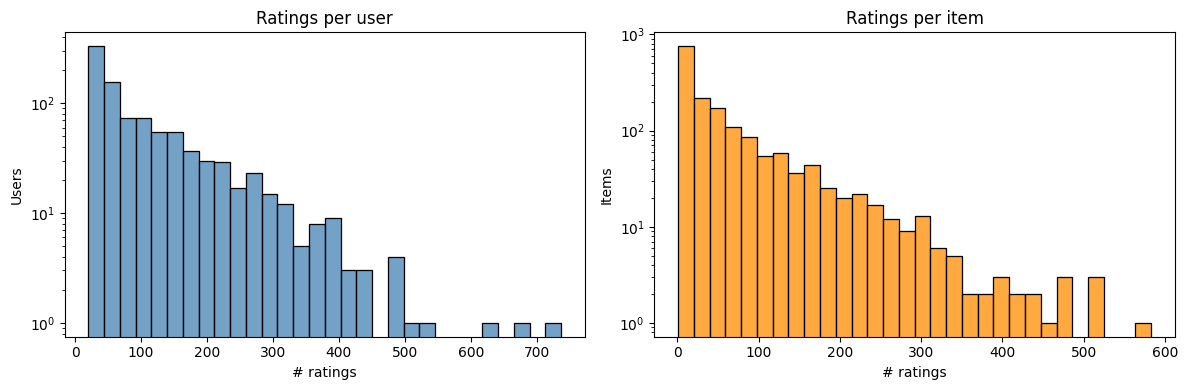

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Counts of ratings per user (rows) and per item (cols)
user_counts = np.sum(~np.isnan(ratings_matrix.values), axis=1)
item_counts = np.sum(~np.isnan(ratings_matrix.values), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(user_counts, bins=30, ax=axes[0], color="steelblue")
axes[0].set_title("Ratings per user")
axes[0].set_xlabel("# ratings")
axes[0].set_ylabel("Users")
axes[0].set_yscale("log")


sns.histplot(item_counts, bins=30, ax=axes[1], color="darkorange")
axes[1].set_title("Ratings per item")
axes[1].set_xlabel("# ratings")
axes[1].set_ylabel("Items")
axes[1].set_yscale("log")


plt.tight_layout()
plt.show()


#### Métricas de Evaluación

In [36]:


# ---------- Helpers ----------

def get_test_indices(R_test):
    """Positions where we have test ratings."""
    return list(zip(*np.where(~np.isnan(R_test))))

def dcg(relevances):
    return sum(rel / np.log2(i + 2) for i, rel in enumerate(relevances))


# ---------- 1. RMSE & MAE ----------

def eval_rmse_mae(R_test, R_pred):
    test_idx = get_test_indices(R_test)
    y_true = [R_test[u, j] for (u, j) in test_idx]
    y_pred = [R_pred[u, j] for (u, j) in test_idx]
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


# ---------- 2. Novelty & Relevance ----------

def eval_novelty_relevance(R_train, R_test, R_pred, top_n=20):
    """
    Novelty: avg(1 / (pop_j + 1)) over top-N recommended unknown items.
    Relevance: mean true rating (if any) on those top-N per user, then avg over users.
    """
    num_users, num_items = R_train.shape
    item_pop = np.sum(~np.isnan(R_train), axis=0)
    inv_pop = 1.0 / (item_pop + 1.0)

    novelty_u = []
    relevance_u = []

    for u in range(num_users):
        known = ~np.isnan(R_train[u])
        unknown_items = np.where(~known)[0]
        if unknown_items.size == 0:
            continue

        k = min(top_n, unknown_items.size)
        top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[::-1][:k]]

        # Novelty
        item_pop = np.sum(~np.isnan(R_train), axis=0)          # users who interacted
        P = (item_pop + 1.0) / (num_users + 2.0)              # Laplace smoothing
        novelty_u.append(np.mean(-np.log2(P[top_items])))

                # Relevance on test ratings (if exist)
        rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
        if rel:
            relevance_u.append(np.mean(rel))

    novelty = float(np.mean(novelty_u)) if novelty_u else np.nan
    relevance = float(np.mean(relevance_u)) if relevance_u else np.nan
    return novelty, relevance



# ---------- 3d. Serendipity (real, con baseline 1-5 reescalado a [0,1]) ----------

def eval_serendipity(R_train, R_test, R_pred,train_df, top_n=20, tau=3.5):
    """
    Ser(u) = (1/|R_u|) * sum_{i in R_u} (1 - base01(u,i)) * I[r_ui >= tau]
    R_u: top-N ítems desconocidos en train para u que sí tienen rating en test.
    base01: baseline de popularidad reescalado a [0,1] (más alto = más esperado).
    """
    # baseline 1..5 (NaN en ítems vistos), mismo que ya tienes
    base15 = popularity_baseline(train_df).values.astype(float)

    # reescalar a [0,1] donde está definido
    base01 = (base15 - 1.0) / 4.0
    base01 = np.clip(base01, 0.0, 1.0)

   # 3) Aseguramos que todo sea numpy float
    R_train = np.asarray(R_train, dtype=float)
    R_test  = np.asarray(R_test,  dtype=float)
    R_pred  = np.asarray(R_pred,  dtype=float)
    m, _ = R_train.shape
    unknown_mask = np.isnan(R_train)

    user_vals = []
    for u in range(m):
        cand = np.where(unknown_mask[u])[0]
        if cand.size == 0:
            continue

        k = min(top_n, cand.size)
        top = cand[np.argsort(R_pred[u, cand])[::-1][:k]]  # Top_u

        has_gt = ~np.isnan(R_test[u, top])  # sólo con ground truth en test
        Ru = top[has_gt]
        if Ru.size == 0:
            continue

        rel = (R_test[u, Ru] >= tau).astype(float)
        ser_u = float(np.mean((1.0 - base01[u, Ru]) * rel))
        user_vals.append(ser_u)

    return float(np.mean(user_vals)) if user_vals else np.nan

# ---------- 4. Diversity ----------

def compute_item_similarity(R_train):
    """Cosine similarity between item vectors (using train, NaNs -> 0)."""
    R_filled = np.nan_to_num(R_train, nan=0.0)
    return cosine_similarity(R_filled.T)

def eval_diversity(R_train, R_pred, item_similarity, top_n=5):
    """
    Diversity(u) = average_{i<j in Top_u} (1 - Sim(i,j)),
    with Top_u being top-N items among those unknown in train.
    Users with <2 items contribute 0. Returns mean over users.
    """
    if top_n <= 1:
        return 0.0  # con 0 o 1 ítem, diversidad es 0 por definición práctica

    R_train = np.asarray(R_train, dtype=float)
    R_pred  = np.asarray(R_pred,  dtype=float)
    S       = np.asarray(item_similarity, dtype=float)

    num_users, _ = R_pred.shape
    div_scores = []

    # reemplaza NaNs en predicciones por -inf para que nunca entren en el top
    R_pred_safe = np.where(np.isnan(R_pred), -np.inf, R_pred)

    for u in range(num_users):
        unknown = np.where(np.isnan(R_train[u]))[0]
        k = min(top_n, unknown.size)

        if k < 2:
            div_scores.append(0.0)
            continue

        # Top_u: top-k por predicción
        top_items = unknown[np.argsort(R_pred_safe[u, unknown])[-k:]]

        # media sobre pares i<j de (1 - sim)
        s = 0.0
        cnt = 0
        for a in range(k):
            for b in range(a + 1, k):
                s += 1.0 - S[top_items[a], top_items[b]]
                cnt += 1

        div_scores.append(s / cnt)

    return float(np.mean(div_scores)) if div_scores else np.nan



# ---------- 5. nDCG@K ----------

def eval_ndcg(R_train, R_test, R_pred, k=20):
    """
    nDCG@k over unknown-in-train items.
    Utility: test rating if available, else 0 (as in the cited definition).
    """
    num_users, _ = R_train.shape
    ndcgs = []

    for u in range(num_users):
        unknown_items = np.where(np.isnan(R_train[u]))[0]
        if unknown_items.size == 0:
            continue

        k_u = min(k, unknown_items.size)

        # Predicted ranking (DESC) among unknown items
        top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[::-1][:k_u]]

        # DCG: gains = true test rating if exists else 0
        rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0.0 for j in top_items]
        dcg_u = dcg(rel_pred)

        # IDCG: ideal ranking by true utilities on the SAME candidate set, missing -> 0
        true_utils = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0.0 for j in unknown_items]
        ideal_rel = sorted(true_utils, reverse=True)[:k_u]
        idcg_u = dcg(ideal_rel)

        if idcg_u > 0:
            ndcgs.append(dcg_u / idcg_u)

    return float(np.mean(ndcgs)) if ndcgs else np.nan


# ---------- 6. Wrapper: one call for everything ----------

def evaluate_all_metrics(R_train, R_test, R_pred, train_df,
                         topn_nov_rel=20, topn_div=5, k_ndcg=20):
    rmse, mae = eval_rmse_mae(R_test, R_pred)
    novelty, relevance = eval_novelty_relevance(R_train, R_test, R_pred,
                                                top_n=topn_nov_rel)
    serendipity = eval_serendipity(R_train, R_test, R_pred, train_df)
    item_sim = compute_item_similarity(R_train)
    diversity = eval_diversity(R_train, R_pred, item_sim, top_n=topn_div)
    ndcg = eval_ndcg(R_train, R_test, R_pred, k=k_ndcg)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Novelty": novelty,
        "Relevance": relevance,
        "Serendipity": serendipity,
        "Diversity": diversity,
        "nDCG@20": ndcg,
    }


In [21]:


# Set seeds for reproducibility
np.random.seed(1)
random.seed(1)

# ratings_matrix: matriz usuarios x películas, ya definida
# Convertimos a array para trabajar con índices más rápido
user_ids = ratings_matrix.index.tolist()
user_indices = np.arange(len(user_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los folds
folds = []

for fold_num, (train_user_idx, test_user_idx) in enumerate(kf.split(user_indices)):
    print(f"\n🔄 Fold {fold_num + 1}")
    
    # Índices de usuarios
    train_users = [user_ids[i] for i in train_user_idx]
    test_users = [user_ids[i] for i in test_user_idx]

    # Crear copias de la matriz completa
    train_matrix = ratings_matrix.copy()
    test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

    skipped_users = 0

    for user in test_users:
        user_ratings = ratings_matrix.loc[user].dropna()

        if len(user_ratings) >= 5:
            test_items = random.sample(list(user_ratings.index), 5)
            for item in test_items:
                # Move rating to test matrix
                test_matrix.at[user, item] = ratings_matrix.at[user, item]
                # Mask it in train
                train_matrix.at[user, item] = np.nan
        else:
            skipped_users += 1  # Opcional: para ver cuántos usuarios se omiten

    # Guarda este fold
    folds.append((train_matrix, test_matrix))

    # Mostrar estadísticas
    train_ratings = np.count_nonzero(~np.isnan(train_matrix.values))
    test_ratings = np.count_nonzero(~np.isnan(test_matrix.values))
    print(f"✅ Train ratings: {train_ratings}")
    print(f"✅ Test ratings: {test_ratings}")
    print(f"🚫 Skipped test users (less than 5 ratings): {skipped_users}")



🔄 Fold 1
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 2
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 3
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 4
✅ Train ratings: 99060
✅ Test ratings: 940
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 5
✅ Train ratings: 99060
✅ Test ratings: 940
🚫 Skipped test users (less than 5 ratings): 0


## Modelos básicos

In [22]:
def global_mean(train):
    mean = np.nanmean(train.values)
    return pd.DataFrame(mean, index=train.index, columns=train.columns)

## Si alguno de los promedios da NaN (p.ej., ítem sin ratings), usar el global mean
def item_mean(train):
    col_means = train.mean(axis=0, skipna=True)
    global_mean = train.stack().mean()
    col_means = col_means.fillna(global_mean)
    return pd.DataFrame(np.tile(col_means.to_numpy(), (train.shape[0], 1)),
                        index=train.index, columns=train.columns)
def user_mean(train):
    row_means = train.mean(axis=1, skipna=True)
    global_mean = train.stack().mean()
    row_means = row_means.fillna(global_mean)
    return pd.DataFrame(np.tile(row_means.to_numpy().reshape(-1, 1), (1, train.shape[1])),
                        index=train.index, columns=train.columns)


def random_baseline(train):
    min_rating = np.nanmin(train.values)
    max_rating = np.nanmax(train.values)
    rand_preds = np.random.uniform(min_rating, max_rating, size=train.shape)
    return pd.DataFrame(rand_preds, index=train.index, columns=train.columns)

def popularity_baseline(train):
    item_popularity = np.sum(~np.isnan(train.values), axis=0)  # número de ratings por ítem
    preds = np.full(train.shape, np.nan)  # empezamos con predicciones vacías

    for u in range(train.shape[0]):
        # Ítems no vistos por el usuario
        unseen_items = np.isnan(train.values[u])
        # Asigna el score de popularidad a esos ítems
        preds[u, unseen_items] = item_popularity[unseen_items]

    # Normaliza por conveniencia (entre 1 y 5 por ejemplo)
    min_score = np.nanmin(preds)
    max_score = np.nanmax(preds)
    if max_score > min_score:
        preds = 1 + 4 * (preds - min_score) / (max_score - min_score)  # normalizar a escala 1-5

    return pd.DataFrame(preds, index=train.index, columns=train.columns)

Evaluación

In [ ]:
all_metrics_basic = []

for fold_num, (train_df, test_df) in enumerate(folds, start=1):
    print(f"\n===== Fold {fold_num} (Modelos básicos) =====")
    R_train = train_df.values
    R_test  = test_df.values

    baselines = [
        ("Global Mean",     global_mean(train_df).values),
        ("User Mean",       user_mean(train_df).values),
        ("Item Mean",       item_mean(train_df).values),
        ("Random [min,max]", random_baseline(train_df).values),
        ("Popularity",      popularity_baseline(train_df).values),
    ]

    for name, R_pred in baselines:
        metrics = evaluate_all_metrics(
            R_train, R_test, R_pred, train_df,
            topn_nov_rel=20, topn_div=5, k_ndcg=20
        )
        metrics.update({
            "Fold": fold_num,
            "Model": name,
        })
        all_metrics_basic.append(metrics)

# ---------- Resultados agregados ----------
basic_results_df = pd.DataFrame(all_metrics_basic)
final_basic_results = (
    basic_results_df
    .groupby(["Model"], as_index=False)
    .mean(numeric_only=True)
)

print("\n📊 RESULTADOS PROMEDIO (Modelos básicos):")
display(final_basic_results[[
    "Model", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG@20"
]])


===== Fold 1 (Modelos básicos) =====

===== Fold 2 (Modelos básicos) =====

===== Fold 3 (Modelos básicos) =====

===== Fold 4 (Modelos básicos) =====

===== Fold 5 (Modelos básicos) =====

📊 RESULTADOS PROMEDIO (Modelos básicos):


,Model,RMSE,MAE,Relevance,Novelty,Serendipity,Diversity,nDCG@20
0,Global Mean,1.131323,0.952467,3.315833,4.740408,0.425912,0.856680,0.002902
1,Item Mean,1.046458,0.835527,4.400417,6.991342,0.526997,1.000000,0.006828
2,Popularity,1.855435,1.564943,3.831671,1.385641,0.207034,0.459176,0.137572
3,"Random [min,max]",1.710692,1.395519,3.326825,5.426521,0.287795,0.919987,0.006398
4,User Mean,1.060559,0.849070,3.315833,4.740408,0.425912,0.856680,0.002902


## Collaborative Filtering

#### Basado en Usuario

##### Pearson

In [ ]:
# ================= CF: USER-BASED PEARSON =================


def compute_similarity_matrix(R_train, user_means):
    U, I = R_train.shape

    rows, cols = np.where(~np.isnan(R_train))
    vals = R_train[rows, cols].astype(np.float32)

    # centered ratings (only where rating exists)
    data = vals - user_means[rows].astype(np.float32)

    C = sp.csr_matrix((data, (rows, cols)), shape=(U, I))
    M = sp.csr_matrix((np.ones_like(data, dtype=np.float32), (rows, cols)), shape=(U, I))

    # Numerator: sum over co-rated items of (r-mean_u)(r-mean_v)
    N = (C @ C.T).toarray().astype(np.float32)

    # S[u,v] = sum over co-rated items of (r_u-mean_u)^2
    S = (C.multiply(C) @ M.T).toarray().astype(np.float32)

    denom = np.sqrt(S * S.T)  # denom[u,v] = sqrt(S[u,v] * S[v,u])

    sim = np.divide(N, denom, out=np.zeros_like(N), where=denom > 0)
    np.fill_diagonal(sim, 0.0)
    return sim


def predict_user_ratings(u, R_train, similarity_matrix, user_means, k, rated_by_item):
    """
    Predict missing ratings for user u using user-based CF with Pearson sim.
    rated_by_item[j]: np.array of users that rated item j in train.
    """
    num_items = R_train.shape[1]
    preds = np.copy(R_train[u])
    sims_u = similarity_matrix[u]
    missing_items = np.where(np.isnan(R_train[u]))[0]
    for j in missing_items:
        if np.isnan(R_train[u, j]):
            neighbors = rated_by_item[j]
            if neighbors.size == 0:
                preds[j] = user_means[u]
                continue

            neighbors = neighbors[neighbors != u]
            if neighbors.size == 0:
                preds[j] = user_means[u]
                continue

            sims = sims_u[neighbors]

            # top-k neighbors by |similarity|
            if k is not None and neighbors.size > k:
                top_idx = np.argpartition(np.abs(sims), -k)[-k:]
                neighbors = neighbors[top_idx]
                sims = sims[top_idx]

            num = np.sum(sims * (R_train[neighbors, j] - user_means[neighbors]))
            denom = np.sum(np.abs(sims))

            preds[j] = user_means[u] if denom == 0 else user_means[u] + num / denom

    return preds

# ================= 5-FOLD EVAL LOOP =================

k_values = [50, 150, 500, None]  # None -> all neighbors
all_folds_metrics = []

for fold_num, (train_matrix, test_matrix) in enumerate(folds, start=1):
    print(f"\n===== Fold {fold_num} =====")

    R_train = train_matrix.values
    R_test = test_matrix.values
    num_users, num_items = R_train.shape

    # User means
    user_means = np.array([
        np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else global_mean
        for u in range(num_users)
    ])

    # User-user Pearson similarity (once per fold)
    print("Computing user-user Pearson similarity...")
    sim_matrix = compute_similarity_matrix(R_train, user_means)

    # For each item, which users rated it (for fast neighbor lookup)
    rated_by_item = [
        np.where(~np.isnan(R_train[:, j]))[0]
        for j in range(num_items)
    ]

   

    for k in k_values:
        print(f"  -> k = {k if k is not None else 'all'}")

        # Predict for all users
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(
                u, R_train, sim_matrix, user_means, k, rated_by_item
            )
            for u in range(num_users)
        )
        R_pred = np.vstack(R_pred_rows)

        # Evaluate with shared metric functions
        metrics = evaluate_all_metrics(
            R_train, R_test, R_pred, train_df,
            topn_nov_rel=20,
            topn_div=5,
            k_ndcg=20
        )

        metrics.update({
            "Fold": fold_num,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Pearson (user-based)"
        })

        all_folds_metrics.append(metrics)

# ================= AGGREGATE RESULTS =================

results_df = pd.DataFrame(all_folds_metrics)

final_results = (
    results_df
    .groupby(["k_neighbors", "Model", "Similarity"], as_index=False)
    .mean(numeric_only=True)
)

print("\n📊 RESULTADOS PROMEDIO POR k:")
print(
    final_results[
        ["k_neighbors", "RMSE", "MAE",
         "Relevance", "Novelty", "Serendipity",
         "Diversity", "nDCG@20"]
    ]
)


===== Fold 1 =====
Computing user-user Pearson similarity...
  -> k = 50
  -> k = 150
  -> k = 500
  -> k = all

===== Fold 2 =====
Computing user-user Pearson similarity...
  -> k = 50
  -> k = 150
  -> k = 500
  -> k = all

===== Fold 3 =====
Computing user-user Pearson similarity...
  -> k = 50
  -> k = 150
  -> k = 500
  -> k = all

===== Fold 4 =====
Computing user-user Pearson similarity...
  -> k = 50


c:\Users\mrari\OneDrive\Desktop\TFG\Sistemas de recomendación\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  -> k = 150
  -> k = 500
  -> k = all

===== Fold 5 =====
Computing user-user Pearson similarity...
  -> k = 50
  -> k = 150
  -> k = 500
  -> k = all

📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  0.979806  0.771537   3.750000  8.367351          1.0   
1         150  0.974857  0.766930   3.500000  8.380335          1.0   
2         500  0.976163  0.768558   3.333333  8.381510          1.0   
3         all  0.976179  0.768585   3.333333  8.381514          1.0   

   Diversity   nDCG@20  
0   0.892753  0.000351  
1   0.892751  0.000330  
2   0.892749  0.000261  
3   0.892749  0.000261  


In [38]:
final_results

,k_neighbors,Model,Similarity,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,Fold
0,50,Memory-based CF,Pearson (user-based),0.979806,0.771537,8.367351,3.750000,1.0,0.892753,0.000351,3.0
1,150,Memory-based CF,Pearson (user-based),0.974857,0.766930,8.380335,3.500000,1.0,0.892751,0.000330,3.0
2,500,Memory-based CF,Pearson (user-based),0.976163,0.768558,8.381510,3.333333,1.0,0.892749,0.000261,3.0
3,all,Memory-based CF,Pearson (user-based),0.976179,0.768585,8.381514,3.333333,1.0,0.892749,0.000261,3.0


#### Basado en Ítems

##### Coseno

In [26]:
def compute_item_similarity_cosine(R_train):
    R_filled = np.nan_to_num(R_train, nan=0.0)
    return cosine_similarity(R_filled.T)

def predict_all_users_item_based(R_train, item_sim, k=None):
    num_users, num_items = R_train.shape
    out = np.copy(R_train)
    for u in range(num_users):
        rated = ~np.isnan(R_train[u])
        rated_idx = np.where(rated)[0]
        rated_r = R_train[u, rated_idx]
        for j in range(num_items):
            if np.isnan(R_train[u, j]):
                sims = item_sim[j, rated_idx]
                if rated_idx.size == 0:
                    out[u, j] = np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0.0
                    continue
                if k is not None and rated_idx.size > k:
                    top_idx = np.argpartition(np.abs(sims), -k)[-k:]
                    sims_k = sims[top_idx]
                    rr = rated_r[top_idx]
                else:
                    sims_k = sims
                    rr = rated_r
                denom = np.sum(np.abs(sims_k))
                out[u, j] = (np.sum(sims_k * rr) / denom) if denom > 0 else (np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0.0)
    return out


In [ ]:
# Evaluación 5-fold para CF basado en ítems (coseno)
k_values = [50, 150, 500, None]  # None -> todos los vecinos
all_folds_metrics_item = []


for fold_num, (train_matrix, test_matrix) in enumerate(folds, start=1):
    print(f"\n===== Fold {fold_num} (Item-based) =====")
    R_train = train_matrix.values
    R_test = test_matrix.values

    print("Computing item-item cosine similarity...")
    item_sim = compute_item_similarity_cosine(R_train)

    for k in k_values:
        print(f"  -> k = {k if k is not None else 'all'}")
        R_pred = predict_all_users_item_based(R_train, item_sim, k)

        metrics = evaluate_all_metrics(
            R_train, R_test, R_pred, train_df,
            topn_nov_rel=20,
            topn_div=5,
            k_ndcg=20
        )


        metrics.update({
            "Fold": fold_num,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Cosine (item-based)"
        })

        all_folds_metrics_item.append(metrics)

results_item_df = pd.DataFrame(all_folds_metrics_item)
final_results_item = (
    results_item_df
    .groupby(["k_neighbors", "Model", "Similarity"], as_index=False)
    .mean(numeric_only=True)
)

print("\n📊 RESULTADOS PROMEDIO POR k (Item-based):")
display(final_results_item[["k_neighbors", "RMSE", "MAE",
                           "Relevance", "Novelty", "Serendipity",
                           "Diversity", "nDCG@20"]])



===== Fold 1 (Item-based) =====
Computing item-item cosine similarity...
  -> k = 50


TypeError: evaluate_all_metrics() got multiple values for argument 'topn_nov_rel'

### Modelos generales

#### Modelos Factoriales Latentes

##### SVD++

In [ ]:

def mf_fit_biased(R_train,
                  n_factors=40,
                  n_epochs=20,
                  lr=0.01,
                  reg=0.05,
                  random_state=42,
                  verbose=False):
    """
    Biased MF: r_hat = mu + b_u + b_i + p_u^T q_i
    R_train: matriz numpy (usuarios x ítems) con NaNs en celdas desconocidas.
    """
    rng = np.random.default_rng(random_state)

    R = R_train.astype(float)
    num_users, num_items = R.shape

    mask = ~np.isnan(R)
    u_idx, i_idx = np.where(mask)
    ratings = R[mask]
    if ratings.size == 0:
        raise ValueError("R_train no tiene ratings conocidos.")

    mu = float(np.mean(ratings))
    bu = np.zeros(num_users, dtype=float)
    bi = np.zeros(num_items, dtype=float)
    P = 0.1 * rng.standard_normal((num_users, n_factors))
    Q = 0.1 * rng.standard_normal((num_items, n_factors))

    n_obs = ratings.shape[0]
    indices = np.arange(n_obs)

    for epoch in range(n_epochs):
        rng.shuffle(indices)
        for k in indices:
            u = u_idx[k]
            i = i_idx[k]
            r_ui = ratings[k]

            pred = mu + bu[u] + bi[i] + P[u] @ Q[i]
            err = r_ui - pred

            bu[u] += lr * (err - reg * bu[u])
            bi[i] += lr * (err - reg * bi[i])

            p_u = P[u]
            q_i = Q[i]

            P[u] += lr * (err * q_i - reg * p_u)
            Q[i] += lr * (err * p_u - reg * q_i)

        if verbose:
            print(f"Epoch {epoch+1}/{n_epochs} terminada")

    return mu, bu, bi, P, Q


def mf_predict_unknown(mu, bu, bi, P, Q, R_train):
    """
    Devuelve matriz R_pred con NaN en celdas conocidas y predicciones en desconocidas.
    """
    R = R_train.astype(float)
    num_users, num_items = R.shape

    full_pred = mu + bu[:, None] + bi[None, :] + P @ Q.T

    R_pred = np.full((num_users, num_items), np.nan, dtype=float)
    mask_unknown = np.isnan(R)
    R_pred[mask_unknown] = full_pred[mask_unknown]
    return R_pred


def evaluate_mf_with_metrics_on_folds(
    folds,
    n_factors=40,
    n_epochs=20,
    lr=0.01,
    reg=0.05,
    random_state=42,
    topn_nov_rel=20,
    topn_div=5,
    k_ndcg=20,
    max_folds=None,
    verbose=False,
):
    rows = []

    for f, (train_df, test_df) in enumerate(folds, 1):
        if max_folds is not None and f > max_folds:
            break

        if verbose:
            print(f"\n=== Fold {f} ===")

        # Muy importante: actualizar las globales que usa eval_diversity
        global R_train, R_test
        R_train = train_df.values.astype(float)
        R_test = test_df.values.astype(float)

        mu, bu, bi, P, Q = mf_fit_biased(
            R_train,
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr=lr,
            reg=reg,
            random_state=random_state + f,  # semilla distinta por fold
            verbose=verbose,
        )

        R_pred = mf_predict_unknown(mu, bu, bi, P, Q, R_train)

        metrics = evaluate_all_metrics(
            R_train, R_test, R_pred, train_df,
            topn_nov_rel=topn_nov_rel,
            topn_div=topn_div,
            k_ndcg=k_ndcg,
        )
        metrics["fold"] = f
        rows.append(metrics)

    metrics_df = pd.DataFrame(rows)
    cols = ["fold"] + [c for c in metrics_df.columns if c != "fold"]
    metrics_df = metrics_df[cols]
    avg_metrics = metrics_df.drop(columns=["fold"]).mean(numeric_only=True).to_dict()
    return metrics_df, avg_metrics


In [29]:
mf_metrics_df, mf_avg_metrics = evaluate_mf_with_metrics_on_folds(
    folds,
    n_factors=40,
    n_epochs=20,
    lr=0.01,
    reg=0.05,
    random_state=42,
    topn_nov_rel=20,
    topn_div=5,
    k_ndcg=20,
    max_folds=None,   # o 1–2 mientras pruebas
    verbose=False,
)

print(mf_metrics_df)
print("Promedio MF:", mf_avg_metrics)


   fold      RMSE       MAE   Novelty  Relevance  Serendipity  Diversity  \
0     1  0.944720  0.743779  3.034728   4.382184          NaN   0.704821   
1     2  0.978627  0.763278  2.989539   4.342199          NaN   0.670113   
2     3  0.921250  0.730451  3.044235   4.575269          NaN   0.701794   
3     4  0.921644  0.733530  3.095201   4.329932          NaN   0.707303   
4     5  0.961670  0.749913  2.989074   4.283688     0.432525   0.684667   

    nDCG@20  
0  0.057466  
1  0.044046  
2  0.061672  
3  0.054313  
4  0.044704  
Promedio MF: {'RMSE': 0.9455821142831233, 'MAE': 0.7441903939920028, 'Novelty': 3.03055541644787, 'Relevance': 4.382654244572418, 'Serendipity': 0.43252457384596243, 'Diversity': 0.6937396518160441, 'nDCG@20': 0.05244020634828974}


In [30]:

def svdpp_fit(R_train,
              n_factors=40,
              n_epochs=20,
              lr=0.01,
              reg=0.05,
              random_state=42,
              use_implicit=True,
              max_items_per_user=None,
              verbose=False):
    """
    SVD++:
      r_hat_ui = mu + b_u + b_i + q_i^T ( p_u + |N(u)|^{-1/2} sum_{j in N(u)} y_j )

    R_train: matriz numpy (usuarios x ítems) con NaNs en celdas desconocidas.
    """
    rng = np.random.default_rng(random_state)

    R = R_train.astype(np.float32)
    num_users, num_items = R.shape

    mask = ~np.isnan(R)
    u_idx, i_idx = np.where(mask)
    ratings = R[mask]
    if ratings.size == 0:
        raise ValueError("R_train no tiene ratings conocidos.")

    # Global mean y parámetros
    mu = float(ratings.mean())
    bu = np.zeros(num_users, dtype=np.float32)
    bi = np.zeros(num_items, dtype=np.float32)

    P = 0.1 * rng.standard_normal((num_users, n_factors)).astype(np.float32)  # user factors
    Q = 0.1 * rng.standard_normal((num_items, n_factors)).astype(np.float32)  # item factors
    Y = 0.1 * rng.standard_normal((num_items, n_factors)).astype(np.float32)  # implicit item factors

    # N(u): ítems valorados por cada usuario (para el término implícito)
    user_items = [list(np.where(mask[u])[0]) for u in range(num_users)]

    n_obs = ratings.shape[0]
    indices = np.arange(n_obs)

    for epoch in range(n_epochs):
        rng.shuffle(indices)
        se = 0.0

        for k in indices:
            u = u_idx[k]
            i = i_idx[k]
            r_ui = ratings[k]

            Nu = user_items[u]
            if max_items_per_user is not None and len(Nu) > max_items_per_user:
                # para aligerar, nos quedamos con un subconjunto
                Nu = Nu[-max_items_per_user:]

            # Vector de usuario efectivo p_u + |N(u)|^-1/2 sum y_j
            if use_implicit and len(Nu) > 0:
                norm = 1.0 / np.sqrt(len(Nu))
                y_sum = Y[Nu].sum(axis=0) * norm
                user_vec = P[u] + y_sum
            else:
                norm = 0.0  # no se usa
                user_vec = P[u]

            # Predicción y error
            pred = mu + bu[u] + bi[i] + np.dot(Q[i], user_vec)
            err = r_ui - pred
            se += err * err

            # Actualizar sesgos
            bu[u] += lr * (err - reg * bu[u])
            bi[i] += lr * (err - reg * bi[i])

            # Guardar copias para las actualizaciones
            p_u = P[u].copy()
            q_i = Q[i].copy()

            # Actualizar factores latentes
            P[u] += lr * (err * q_i - reg * p_u)
            Q[i] += lr * (err * user_vec - reg * q_i)

            # Actualizar factores implícitos Y_j
            if use_implicit and len(Nu) > 0:
                # broadcast: cada Y[j] se mueve en la misma dirección
                Y[Nu] += lr * (err * norm * q_i - reg * Y[Nu])

        if verbose:
            rmse = np.sqrt(se / n_obs)
            print(f"Epoch {epoch+1}/{n_epochs} — train RMSE: {rmse:.4f}")

    # devolvemos también user_items para usar N(u) en la fase de predicción
    return mu, bu, bi, P, Q, Y, user_items
def svdpp_predict_unknown(mu, bu, bi, P, Q, Y, user_items, R_train,
                          use_implicit=True,
                          max_items_per_user=None):
    """
    Devuelve matriz R_pred con NaN en celdas conocidas y predicciones en desconocidas,
    usando la fórmula de SVD++.
    """
    R = R_train.astype(float)
    num_users, num_items = R.shape

    full_pred = np.zeros((num_users, num_items), dtype=float)

    for u in range(num_users):
        Nu = user_items[u]
        if max_items_per_user is not None and len(Nu) > max_items_per_user:
            Nu = Nu[-max_items_per_user:]

        # vector de usuario efectivo
        if use_implicit and len(Nu) > 0:
            norm = 1.0 / np.sqrt(len(Nu))
            y_sum = Y[Nu].sum(axis=0) * norm
            user_vec = P[u] + y_sum
        else:
            user_vec = P[u]

        # μ + b_u + b_i + q_i^T user_vec  para todos los ítems de golpe
        full_pred[u, :] = mu + bu[u] + bi + Q @ user_vec

    R_pred = np.full((num_users, num_items), np.nan, dtype=float)
    mask_unknown = np.isnan(R)
    R_pred[mask_unknown] = full_pred[mask_unknown]
    return R_pred



In [31]:
import numpy as np

def svdpp_fit_fast(
    R_train,
    n_factors=40,
    n_epochs=20,
    lr=0.01,
    reg=0.05,
    random_state=42,
    use_implicit=True,
    max_items_per_user=None,
    verbose=False,
):
    """
    SVD++ (versión rápida):
      - Recorre por usuario
      - Cachea y_sum = |N(u)|^-1/2 * sum_{j in N(u)} Y[j] una vez por usuario
      - Actualiza Y de forma agregada (1 vez por usuario y época)
      - Si max_items_per_user: submuestreo aleatorio sin sesgo (NO "los últimos")

    R_train: np.array (U x I) con NaNs en desconocidos.
    """
    rng = np.random.default_rng(random_state)

    R = R_train.astype(np.float32)
    num_users, num_items = R.shape

    mask = ~np.isnan(R)
    ratings = R[mask]
    if ratings.size == 0:
        raise ValueError("R_train no tiene ratings conocidos.")

    mu = float(ratings.mean())
    bu = np.zeros(num_users, dtype=np.float32)
    bi = np.zeros(num_items, dtype=np.float32)

    P = (0.1 * rng.standard_normal((num_users, n_factors))).astype(np.float32)
    Q = (0.1 * rng.standard_normal((num_items, n_factors))).astype(np.float32)
    Y = (0.1 * rng.standard_normal((num_items, n_factors))).astype(np.float32)

    # Para cada usuario, guardamos los ítems valorados y sus ratings (para iterar rápido)
    user_items_full = []
    user_ratings_full = []
    for u in range(num_users):
        items_u = np.where(mask[u])[0]
        user_items_full.append(items_u.astype(np.int32))
        user_ratings_full.append(R[u, items_u].astype(np.float32))

    for epoch in range(n_epochs):
        users = np.arange(num_users)
        rng.shuffle(users)

        se = 0.0
        n_obs = 0

        for u in users:
            items_u = user_items_full[u]
            if items_u.size == 0:
                continue

            # --------- término implícito (cacheado una vez por usuario) ---------
            Nu = items_u
            y_sum = 0.0  # vector o escalar según caso
            norm = 0.0

            if use_implicit and Nu.size > 0:
                if max_items_per_user is not None and Nu.size > max_items_per_user:
                    # submuestreo aleatorio SIN sesgo por id
                    Nu = rng.choice(Nu, size=max_items_per_user, replace=False)
                norm = (1.0 / np.sqrt(Nu.size)).astype(np.float32)
                y_sum = Y[Nu].sum(axis=0) * norm  # (n_factors,)

            # Acumulador del gradiente para Y (una sola actualización al final)
            grad_y = np.zeros(n_factors, dtype=np.float32)

            # --------- iteramos ratings del usuario u ---------
            # (explicit: recorremos todos los ratings observados del usuario)
            for i, r_ui in zip(items_u, user_ratings_full[u]):
                user_vec = P[u] + (y_sum if (use_implicit and Nu.size > 0) else 0.0)

                pred = mu + bu[u] + bi[i] + np.dot(Q[i], user_vec)
                err = r_ui - pred

                se += float(err * err)
                n_obs += 1

                # biases
                bu[u] += lr * (err - reg * bu[u])
                bi[i] += lr * (err - reg * bi[i])

                # copias para gradientes consistentes
                p_u_old = P[u].copy()
                q_i_old = Q[i].copy()

                # factores
                P[u] += lr * (err * q_i_old - reg * p_u_old)
                Q[i] += lr * (err * user_vec - reg * q_i_old)

                # acumulamos contribución a Y (evita tocar |Nu| filas aquí)
                if use_implicit and Nu.size > 0:
                    grad_y += err * q_i_old

            # --------- actualización agregada de Y (1 vez por usuario) ---------
            if use_implicit and Nu.size > 0:
                # Ajuste: el término de regularización en tu versión se aplica "por rating".
                # Aquí lo aproximamos escalándolo por el nº de ratings del usuario en esta época.
                m = items_u.size  # nº de observaciones del usuario (aprox. "por rating")
                Y[Nu] += lr * (norm * grad_y - (reg * m) * Y[Nu])

        if verbose and n_obs > 0:
            rmse = np.sqrt(se / n_obs)
            print(f"Epoch {epoch+1}/{n_epochs} — train RMSE: {rmse:.4f}")

    # devolvemos user_items_full (historial completo) para predicción
    return mu, bu, bi, P, Q, Y, user_items_full


def svdpp_predict_unknown(
    mu, bu, bi, P, Q, Y, user_items, R_train,
    use_implicit=True,
    max_items_per_user=None,
    random_state=42,
):
    """
    Predice SOLO en celdas desconocidas (NaN), dejando NaN en las conocidas.
    Si max_items_per_user: usa submuestreo determinista por usuario (para que no "baile").
    """
    R = R_train.astype(float)
    num_users, num_items = R.shape

    full_pred = np.zeros((num_users, num_items), dtype=float)

    for u in range(num_users):
        Nu = user_items[u]
        if use_implicit and Nu.size > 0:
            if max_items_per_user is not None and Nu.size > max_items_per_user:
                # determinista por usuario para estabilidad
                rng_u = np.random.default_rng(random_state + int(u))
                Nu_eff = rng_u.choice(Nu, size=max_items_per_user, replace=False)
            else:
                Nu_eff = Nu

            norm = 1.0 / np.sqrt(Nu_eff.size)
            y_sum = Y[Nu_eff].sum(axis=0) * norm
            user_vec = P[u] + y_sum
        else:
            user_vec = P[u]

        full_pred[u, :] = mu + bu[u] + bi + (Q @ user_vec)

    R_pred = np.full((num_users, num_items), np.nan, dtype=float)
    mask_unknown = np.isnan(R)
    R_pred[mask_unknown] = full_pred[mask_unknown]
    return R_pred


In [32]:
def evaluate_svdpp_with_metrics_on_folds(
    folds,
    n_factors=40,
    n_epochs=20,
    lr=0.01,
    reg=0.05,
    random_state=42,
    topn_nov_rel=20,
    topn_div=5,
    k_ndcg=20,
    max_folds=None,
    use_implicit=True,
    max_items_per_user=None,
    verbose=False,
):
    rows = []

    for f, (train_df, test_df) in enumerate(folds, 1):
        if max_folds is not None and f > max_folds:
            break

        if verbose:
            print(f"\n=== Fold {f} ===")

        # Muy importante: actualizar las globales que usa eval_diversity
        global R_train, R_test
        R_train = train_df.values.astype(float)
        R_test = test_df.values.astype(float)

        mu, bu, bi, P, Q, Y, user_items = svdpp_fit_fast(
            R_train,
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr=lr,
            reg=reg,
            random_state=random_state + f,
            use_implicit=use_implicit,
            max_items_per_user=max_items_per_user,
            verbose=verbose,
        )

        R_pred = svdpp_predict_unknown(
            mu, bu, bi, P, Q, Y, user_items, R_train,
            use_implicit=use_implicit,
            max_items_per_user=max_items_per_user,
        )

        metrics = evaluate_all_metrics(
            R_train, R_test, R_pred, train_df,
            topn_nov_rel=topn_nov_rel,
            topn_div=topn_div,
            k_ndcg=k_ndcg,
        )
        metrics["fold"] = f
        rows.append(metrics)

    metrics_df = pd.DataFrame(rows)
    cols = ["fold"] + [c for c in metrics_df.columns if c != "fold"]
    metrics_df = metrics_df[cols]
    avg_metrics = metrics_df.drop(columns=["fold"]).mean(numeric_only=True).to_dict()
    return metrics_df, avg_metrics

metrics_df, avg_metrics = evaluate_svdpp_with_metrics_on_folds(
    folds,
    n_factors=40,
    n_epochs=20,
    lr=0.001,
    reg=0.05,
    use_implicit=True
    ,          # SVD++
    max_items_per_user=20,      # para aligerar
    verbose=False
)
print(avg_metrics)     # promedio sobre folds


{'RMSE': 0.9917634227098485, 'MAE': 0.7881659490046544, 'Novelty': 2.2303338300469955, 'Relevance': 4.243490247678328, 'Serendipity': 0.379919028340081, 'Diversity': 0.5637153834420554, 'nDCG@20': 0.05754468565112882}
